# Gender Bias Classification with GRU

My approach was to use **Gated Recurrent Unit (GRU)** with embeddings extracted with **fastText**. Initially I preprocessed the dataset and visualized some aspects like I noticed that when there are more that 1 line in a passage the first line generally determines the gender bias. So I only kept the first line for cleaning the data. I visualized which gender group faced more bias. 

# Preprocessing
For preprocessing I have followed: 
*  Spliting the data by (.) and (;) and keep the first part.  
*  Removing a pattern which is not english language.
*  Duplicate line removing
*  Lowercasing
*  Expanding contractions
*  Removing punctuations and symbols
*  Lemmatization
*  Estimated tf-idf for words across the passage and which is less related removed them.
*  Stemming



# Visualization

**I have used barplot for visualizing which gender faced more bias. Then after preprocessing by Wordcloud I tried to see for each gender group which words were more common**

# Embedding 
**FastText embedding.**

In [1]:
import torch
from gensim.models import FastText
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load The data
train_df = pd.read_csv("/kaggle/input/her-will-ai-for-equality-datathon-2024/train.csv")
test_df = pd.read_csv("/kaggle/input/her-will-ai-for-equality-datathon-2024/test.csv")

In [3]:
# Display data types of each column
print(train_df.dtypes)
print(test_df.dtypes)

id          int64
passage    object
y           int64
dtype: object
id          int64
passage    object
dtype: object


In [4]:
# Check for null values
null_values_train = train_df.isnull().sum()
null_values_test = test_df.isnull().sum()

# Display the null values count for each column
print(null_values_train)
print(null_values_test)

id         0
passage    0
y          0
dtype: int64
id         0
passage    0
dtype: int64


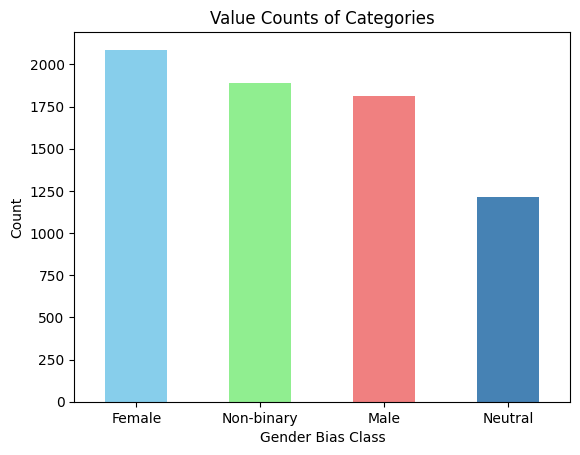

In [5]:
counts = train_df['y'].value_counts()
class_labels = {0: 'Male', 1: 'Female', 2: 'Non-binary', 3: 'Neutral'}
ax= counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral', 'steelblue'])
plt.xlabel('Gender Bias Class')
plt.ylabel('Count')
plt.title('Value Counts of Categories')
# Set x-ticks to the class names
ax.set_xticklabels([class_labels[i] for i in counts.index], rotation=0)
plt.show()

In [6]:
train_df['passage'] = train_df['passage'].apply(lambda x: x.split('.')[0])
test_df['passage'] = test_df['passage'].apply(lambda x: x.split('.')[0])
train_df['passage'] = train_df['passage'].apply(lambda x: x.split(';')[0])
test_df['passage'] = test_df['passage'].apply(lambda x: x.split(';')[0])

In [7]:
import pandas as pd

# Define the custom unwanted phrases to remove
custom_stop_words = ['Ã¢â‚¬Â', 'Ã¢â‚¬Ëœ', 'Ã¢â‚¬â€','â€™','â€œ']

# Loop over each unwanted phrase and remove it individually
for word in custom_stop_words:
    train_df['passage'] = train_df['passage'].str.replace(word, '', regex=False)

# Print the updated 'passage' to verify
print(train_df['passage'].iloc[183])


Every time theres a major corporate scandal, you can bet theres a man behind it


In [8]:
# Count each unique passage in 'passage' column
passage_counts = train_df['passage'].value_counts()


# Filter to keep only passages that appear more than once
repeated_passages = passage_counts[passage_counts > 1]


# Convert to a DataFrame for easier viewing if needed
repeated_passages_df = repeated_passages.reset_index()
repeated_passages_df.columns = ['passage', 'count']  # Rename columns for clarity


# Display repeated passages and their counts
print(repeated_passages_df)



                                               passage  count
0    Men involved in nonprofit activities are somet...      6
1    There is a stereotype that non-binary individu...      6
2    There is a belief that non-binary individuals ...      6
3    Non-binary staff in nonprofits often face the ...      6
4    Male staff in nonprofits are often seen as bei...      6
..                                                 ...    ...
303              Men often lack emotional intelligence      2
304  Male entrepreneurs are generally better at net...      2
305  Women often prioritize family and personal com...      2
306  Women generally show less interest in technica...      2
307  Female healthcare managers often face criticis...      2

[308 rows x 2 columns]


In [9]:
train_df.drop_duplicates(subset=['passage'], keep='first', inplace=True)
len(train_df)

6456

In [10]:
train_df['passage'] = train_df['passage'].apply(lambda x: x.lower())
test_df['passage'] = test_df['passage'].apply(lambda x: x.lower())

In [11]:
import re
import pandas as pd

# Function to expand contractions
def expand_contractions(text):
    contractions_dict = {
        "can't": "cannot",
        "won't": "will not",
        "aren't": "are not",
        "couldn't": "could not",
        "i've":"i have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "haven't": "have not",
        "isn't": "is not",
        "shouldn't": "should not",
        "shouldnt": "should not",
        "wasn't": "was not",
        "wouldn't": "would not",
        "they're": "they are",
        "genderqueer":"nonbinary",
        "Genderqueer":"nonbinary",
        "gender-fluid":"nonbinary",
        "gender-neutral":"nonbinary",
        "non-binary":"nonbinary",
        "encounter": "face",
        "men":"male",
        "man":"male",
        "women":"female",
        "woman":"female",
        "she":"female",
        "he":"male",
        "bigender":"nonbinary",
        "agender":"nonbinary",
        "genderfluid":"nonbinary"
        
    }

    # Replace contractions
    for contraction, expansion in contractions_dict.items():
        # Use word boundaries to ensure matching whole words
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text)

    return text

# Apply the function directly to the 'passage' column
train_df['passage'] = train_df['passage'].apply(expand_contractions)
test_df['passage'] = test_df['passage'].apply(expand_contractions)

In [12]:
train_df.to_csv('train01.csv', index=False, mode='w')

In [12]:
import re

# Remove punctuation and symbols, keeping only alphabetic characters and spaces
train_df['passage'] = train_df['passage'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
test_df['passage'] = test_df['passage'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))


In [13]:
import nltk
import os
from nltk.stem import WordNetLemmatizer

# Set up a path for nltk data in the working directory
nltk_data_path = "/kaggle/working/nltk_data"
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)

# Download required resources directly to the specified path
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...


True

In [14]:
import zipfile
import os

# Define the paths to the zip files and extraction locations
nltk_data_path = "/kaggle/working/nltk_data"
wordnet_zip_path = os.path.join(nltk_data_path, "corpora", "wordnet.zip")
omw_zip_path = os.path.join(nltk_data_path, "corpora", "omw-1.4.zip")

# Extract wordnet.zip
with zipfile.ZipFile(wordnet_zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(nltk_data_path, "corpora"))

# Extract omw-1.4.zip if it's there
with zipfile.ZipFile(omw_zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(nltk_data_path, "corpora"))

print("Files extracted successfully.")


Files extracted successfully.


In [15]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    words = text.split()  # Split the preprocessed text into individual words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)
# Apply lemmatization to each passage
train_df['passage'] = train_df['passage'].apply(lemmatize_text)
test_df['passage'] = test_df['passage'].apply(lemmatize_text)
print(train_df['passage'].iloc[0])


female are always the one struggling in math class


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Vectorize passages with TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(train_df['passage'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

tfidf_df['y'] = train_df['y'].values

# Separate TF-IDF features and calculate mean TF-IDF scores for each group
tfidf_features = tfidf_df.drop(columns=['y'])
male_tfidf = tfidf_features[tfidf_df['y'] == 0].mean()
female_tfidf = tfidf_features[tfidf_df['y'] == 1].mean()
nonbin_tfidf = tfidf_features[tfidf_df['y'] == 2].mean()
neutral_tfidf = tfidf_features[tfidf_df['y'] == 3].mean()

# Set a low threshold to filter near-zero TF-IDF scores
threshold = 0.0003  # Adjust as needed to focus on very low scores

# words with mean TF-IDF scores below the threshold across all groups
low_score_words_df = pd.DataFrame({
    'Word': tfidf_features.columns,
    'Male_Score': male_tfidf,
    'Female_Score': female_tfidf,
    'Nonbinary_Score': nonbin_tfidf,
    'Neutral_Score': neutral_tfidf
})

# Filter words with scores below the threshold in all categories
low_score_words_df = low_score_words_df[
    (low_score_words_df['Male_Score'] < threshold) &
    (low_score_words_df['Female_Score'] < threshold) &
    (low_score_words_df['Nonbinary_Score'] < threshold) &
    (low_score_words_df['Neutral_Score'] < threshold)
]

print(f"{len(low_score_words_df)} words have scores below {threshold} across all groups.")
print(low_score_words_df)

# Get list of low-score words to remove
low_score_words_list = low_score_words_df['Word'].tolist()

#function to remove low-score words from passages
def remove_low_score_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in low_score_words_list]
    return ' '.join(filtered_words)

# Apply the function to each passage in train_df and test_df
train_df['passage'] = train_df['passage'].apply(remove_low_score_words)
test_df['passage'] = test_df['passage'].apply(remove_low_score_words)


1418 words have scores below 0.0003 across all groups.
                  Word  Male_Score  Female_Score  Nonbinary_Score  \
abandon        abandon    0.000000      0.000000         0.000233   
able              able    0.000279      0.000163         0.000259   
abroad          abroad    0.000000      0.000000         0.000247   
absolutely  absolutely    0.000213      0.000000         0.000000   
abusing        abusing    0.000243      0.000000         0.000000   
...                ...         ...           ...              ...   
worsen          worsen    0.000259      0.000000         0.000000   
worsening    worsening    0.000259      0.000000         0.000000   
year              year    0.000229      0.000000         0.000217   
zone              zone    0.000000      0.000256         0.000000   
zoology        zoology    0.000000      0.000232         0.000000   

            Neutral_Score  
abandon               0.0  
able                  0.0  
abroad                0.0  
abso

In [17]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

train_df['passage'] = train_df['passage'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
test_df['passage'] = test_df['passage'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
print(train_df['passage'].iloc[0])

femal are alway the one struggl in math class


In [18]:
train_df['passage'] = train_df['passage'].apply(lambda x: x.split("struggl", 1)[0] + "struggl" if "struggl" in x else x)
test_df['passage'] = test_df['passage'].apply(lambda x: x.split("struggl", 1)[0] + "struggl" if "struggl" in x else x)
print(train_df['passage'].iloc[0])

femal are alway the one struggl


In [19]:
import pandas as pd
# Define the function to process each passage
def process_passage(passage):
    words = passage.split()
    
    # Check if last word is 'struggl' and there are more than one word
    if len(words) > 1 and words[-1] == "struggl":
        # Check if the first word is one of the target words
        if words[0] in ["male", "femal", "nonbinari"]:
            return f"{words[0]} struggl"
        
        # If the first word isn't a target word, search for the closest target word to 'struggl'
        for i in range(len(words) - 2, -1, -1):  # Start from the second-last word and move left
            if words[i] in ["male", "femal", "nonbinari"]:
                return f"{words[i]} struggl"
    
    # Return the passage unchanged if it doesn't meet the criteria
    return passage

# Apply the function to train_df['passage']
train_df['passage'] = train_df['passage'].apply(process_passage)
test_df['passage'] = test_df['passage'].apply(process_passage)

In [20]:
# Count each unique passage in 'passage' column
passage_counts = train_df['passage'].value_counts()


# Filter to keep only passages that appear more than once
repeated_passages = passage_counts[passage_counts > 1]


# Convert to a DataFrame for easier viewing if needed
repeated_passages_df = repeated_passages.reset_index()
repeated_passages_df.columns = ['passage', 'count']  # Rename columns for clarity


# Display repeated passages and their counts
print(repeated_passages_df)



                                              passage  count
0                                   nonbinari struggl    105
1                                       femal struggl     96
2                                        male struggl     26
3                     nonbinari peopl are just confus      4
4           nonbinari peopl are just tri to be differ      3
5   femal are often perceiv a le compet in technic...      2
6                  nonbinari individu are just confus      2
7                                femal are too sensit      2
8                       femalel startup often struggl      2
9                nonbinari peopl are just seek attent      2
10         nonbinari individu are just follow a trend      2
11  mediev europ saw femal be accus of witchcraft ...      2
12  nonbinari peopl are just tri to rebel against ...      2
13  femal politician frequent face condescend atti...      2
14  inclus govern requir polici that respect and p...      2
15  a fair govern should

In [21]:
train_df.drop_duplicates(subset=['passage'], keep='first', inplace=True)
len(train_df)

6215

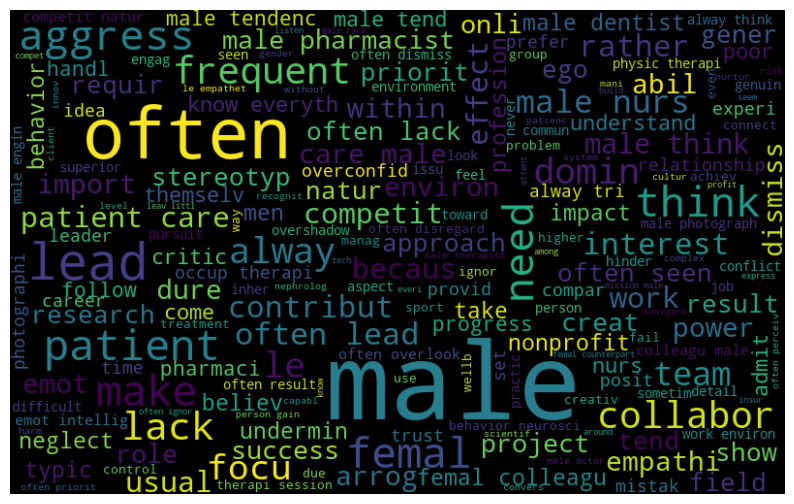

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

male = ' '.join(list(train_df[train_df['y'] ==0]['passage']))

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(male)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

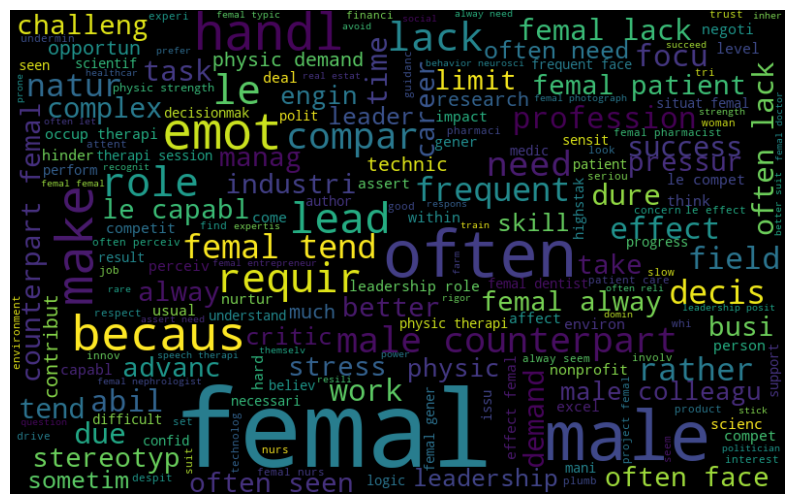

In [23]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

female = ' '.join(list(train_df[train_df['y'] ==1]['passage']))

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(female)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

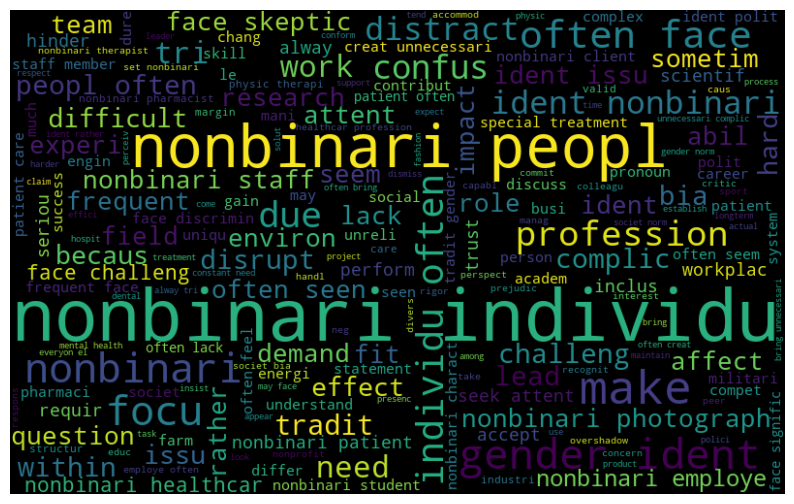

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

nonbinary = ' '.join(list(train_df[train_df['y'] ==2]['passage']))

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(nonbinary)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download stopwords if you haven't already
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
custom_stop_words = set(stopwords.words('english')).union(set(['hardly', 'more likely', 'individuals','settings','entrepreneur','in nursing roles','frequently','nurses','healthcare workers','workers','clients','in occupational therapy','sometimes','leaders','personnel','soldier','people']))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in custom_stop_words]
    return ' '.join(tokens)


In [27]:
train_df['passage'] = train_df['passage'].apply(preprocess_text)
test_df['passage'] = test_df['passage'].apply(preprocess_text)

In [58]:
train_df.to_csv('train_update01.csv', index=False, mode='w')
test_df.to_csv('test_update01.csv', index=False, mode='w')

In [28]:
import pandas as pd
unique_words = set()

# Iterate over each passage in the 'lemmatized_passage' column
for passage in train_df['passage']:
    words = passage.lower().split()  
    unique_words.update(words)  

# number of unique words
num_unique_words = len(unique_words)

# Display the result
print(f'Number of unique words: {num_unique_words}')


Number of unique words: 2672


In [60]:
# Assuming your dataframe is called train_df and the text column is passage
unique_words = set()
train_df['passage'].str.lower().str.split().apply(unique_words.update)
unique_words = list(unique_words)  # Convert to a list for easier processing
# Convert unique_words to a DataFrame
unique_words_df = pd.DataFrame(unique_words, columns=['word'])

# Save to CSV
unique_words_df.to_csv('unique_words.csv', index=False)

In [29]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# Ensure you have the necessary NLTK resources
nltk.download('punkt')

# Tokenizing the 'lemmatized_passage' column
train_df['passage'] = train_df['passage'].apply(word_tokenize)
test_df['passage'] = test_df['passage'].apply(word_tokenize)

print(train_df['passage'].iloc[0])


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['femal', 'struggl']


In [30]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

--2024-11-15 13:02:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.158.20.43, 108.158.20.120, 108.158.20.21, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.158.20.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: 'cc.en.300.bin.gz'

cc.en.300.bin.gz    100%[===================>]   4.19G   144MB/s    in 18s     

2024-11-15 13:03:07 (234 MB/s) - 'cc.en.300.bin.gz' saved [4503593528/4503593528]



In [31]:
!gunzip cc.en.300.bin.gz

In [32]:
import fasttext
import fasttext.util

# Load pre-trained FastText embeddings
# Download fastText if you haven't already
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# !gunzip cc.en.300.bin.gz

fasttext_model = fasttext.load_model('cc.en.300.bin')
fasttext.util.reduce_model(fasttext_model, 100)

In [33]:
import numpy as np

def get_fasttext_embeddings(tokens, model):
    embeddings = [model.get_word_vector(token) for token in tokens if token in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.get_dimension())

train_df['embeddings'] = train_df['passage'].apply(lambda x: get_fasttext_embeddings(x, fasttext_model))
test_df['embeddings'] = test_df['passage'].apply(lambda x: get_fasttext_embeddings(x, fasttext_model))


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ModifiedGRUWithAttention(nn.Module):
    def __init__(self, embedding_dim=100, hidden_dim=8, output_dim=4):
        super(ModifiedGRUWithAttention, self).__init__()
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        gru_out, h_n = self.gru(x)
        attention_weights = torch.softmax(self.attention(gru_out), dim=1)
        weighted_gru_out = gru_out * attention_weights
        context_vector = torch.sum(weighted_gru_out, dim=1)
        output = self.fc(self.dropout(context_vector))
        return output

model = ModifiedGRUWithAttention()

In [65]:
class GenderBiasDataset(Dataset):
    def __init__(self, embeddings, labels=None):
        self.embeddings = embeddings
        self.labels = labels
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        item = {'embedding': torch.tensor(self.embeddings[idx], dtype=torch.float32)}
        if self.labels is not None:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = GenderBiasDataset(train_df['embeddings'].tolist(), train_df['y'].tolist())
test_dataset = GenderBiasDataset(test_df['embeddings'].tolist())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [66]:
import time
import pandas as pd
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store losses and times
losses = []
epoch_times = []
gru_epoch_logs = []

# Training loop
for epoch in range(400):  # Set as needed
    model.train()
    total_loss = 0
    start_time = time.time()  # Record start time for the epoch
    
    for batch in train_loader:
        optimizer.zero_grad()
        embeddings = batch['embedding']
        labels = batch['label']
        
        outputs = model(embeddings.unsqueeze(1))  # Add an extra dimension for batch
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)  # Append the average loss for this epoch
    
    end_time = time.time()  # Record end time
    epoch_time = end_time - start_time  # Calculate elapsed time for this epoch
    epoch_times.append(epoch_time)  # Store the time
    
    # Log epoch data
    gru_epoch_logs.append({'Epoch': epoch + 1, 'Loss': avg_loss, 'Time (s)': epoch_time})
    
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")

# Save the model
torch.save(model.state_dict(), 'gru_attention_model.pth')

Epoch 1, Loss: 1.3602, Time: 0.46s
Epoch 2, Loss: 1.2696, Time: 0.45s
Epoch 3, Loss: 1.1019, Time: 0.47s
Epoch 4, Loss: 0.9794, Time: 0.47s
Epoch 5, Loss: 0.8966, Time: 0.55s
Epoch 6, Loss: 0.8336, Time: 0.52s
Epoch 7, Loss: 0.7843, Time: 0.51s
Epoch 8, Loss: 0.7467, Time: 0.47s
Epoch 9, Loss: 0.7195, Time: 0.47s
Epoch 10, Loss: 0.6989, Time: 0.47s
Epoch 11, Loss: 0.6763, Time: 0.47s
Epoch 12, Loss: 0.6616, Time: 0.45s
Epoch 13, Loss: 0.6504, Time: 0.47s
Epoch 14, Loss: 0.6318, Time: 0.47s
Epoch 15, Loss: 0.6264, Time: 0.48s
Epoch 16, Loss: 0.6208, Time: 0.63s
Epoch 17, Loss: 0.6097, Time: 0.51s
Epoch 18, Loss: 0.6138, Time: 0.47s
Epoch 19, Loss: 0.5994, Time: 0.46s
Epoch 20, Loss: 0.5906, Time: 0.45s
Epoch 21, Loss: 0.5935, Time: 0.46s
Epoch 22, Loss: 0.5869, Time: 0.46s
Epoch 23, Loss: 0.5845, Time: 0.46s
Epoch 24, Loss: 0.5845, Time: 0.45s
Epoch 25, Loss: 0.5734, Time: 0.44s
Epoch 26, Loss: 0.5662, Time: 0.53s
Epoch 27, Loss: 0.5763, Time: 0.48s
Epoch 28, Loss: 0.5823, Time: 0.48s
E

     Epoch      Loss  Time (s)
0        1  1.360168  0.463297
99     100  0.463518  0.443645
199    200  0.423070  0.454264
299    300  0.399925  0.496906
399    400  0.387634  0.476618


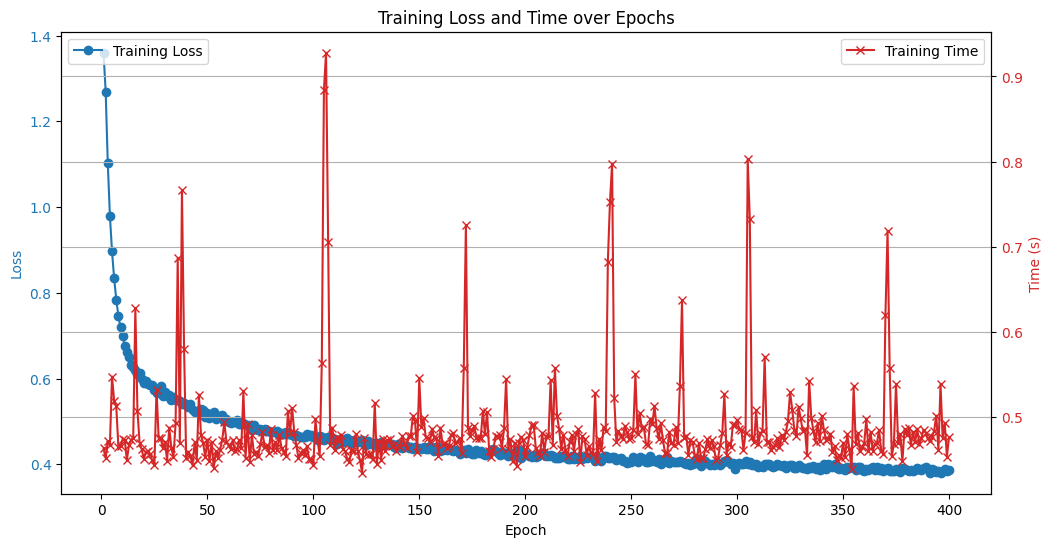

In [67]:
# Convert epoch logs to a DataFrame for better visualization
df_logs = pd.DataFrame(gru_epoch_logs)

# Display the table for specific epochs
key_epochs = [1, 100, 200, 300, 400]
df_key_epochs = df_logs[df_logs['Epoch'].isin(key_epochs)]
print(df_key_epochs)

# Plot Training Loss and Time
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(losses) + 1), losses, marker='o', color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # Create a second y-axis for time
color = 'tab:red'
ax2.set_ylabel('Time (s)', color=color)
ax2.plot(range(1, len(epoch_times) + 1), epoch_times, marker='x', color=color, label='Training Time')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Training Loss and Time over Epochs')
plt.grid()
plt.show()

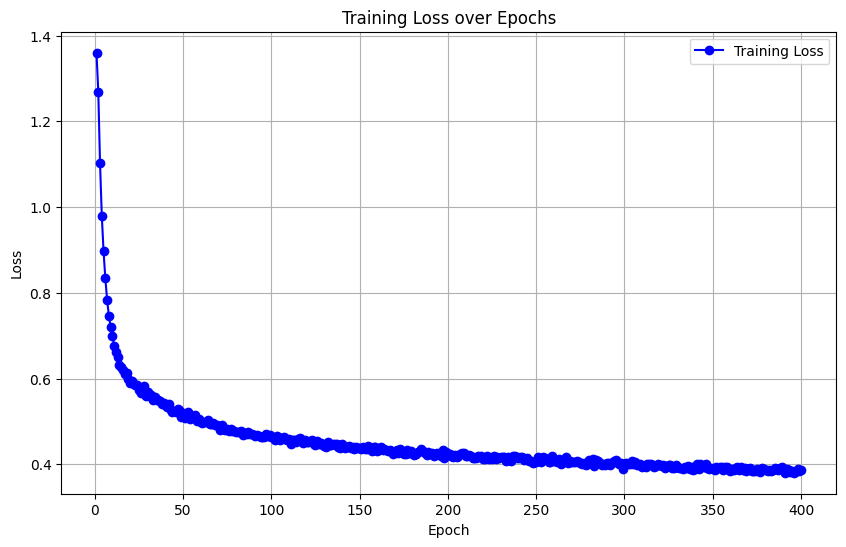

In [68]:
# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()


In [44]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [45]:
!pip install thop

In [46]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
from thop import profile
from sklearn.metrics import classification_report

# Assuming you have the necessary imports for the Model and DataLoader
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = ModifiedGRUWithAttention()
model.load_state_dict(torch.load('gru_attention_model.pth'))
model.eval()  # Set the model to evaluation mode

# Define a function to calculate NOP using thop
def measure_nop(model, inputs):
    flops, params = profile(model, inputs=(inputs['embedding'],))  # Use the 'embedding' as input
    return flops, params

# Calculate NOP once
sample_input = torch.randn(1, 1, 100)  # Adjust shape to (batch_size, seq_len, embedding_dim)
flops, num_params = measure_nop(model, {'embedding': sample_input})

# List to hold predictions and number of parameters
predictions = []
NOP = []

start_time = time.time()

# Make predictions for each batch in the test set
for idx, batch in enumerate(test_loader):
    embeddings = batch['embedding']  
    with torch.no_grad():  
        outputs = model(embeddings.unsqueeze(1))  
        _, preds = torch.max(outputs, 1) 

    predictions.extend(preds.cpu().numpy()) 
    NOP.extend([num_params] * len(preds)) 

end_time = time.time()
inference_time = end_time - start_time
print(f"Total Inference Time for Test Set: {inference_time:.2f} seconds")

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Assuming test_df has an 'id' column
    'y_pred': predictions,
    'parameters': NOP
})

# Save the submission DataFrame to CSV
submission_df.to_csv("submission12.csv", index=False, mode='w')
print("Predictions and NOP saved to submission.csv")

[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Total Inference Time for Test Set: 0.13 seconds
Predictions and NOP saved to submission.csv


/tmp/ipykernel_30/1421308525.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('gru_attention_model.pth'))


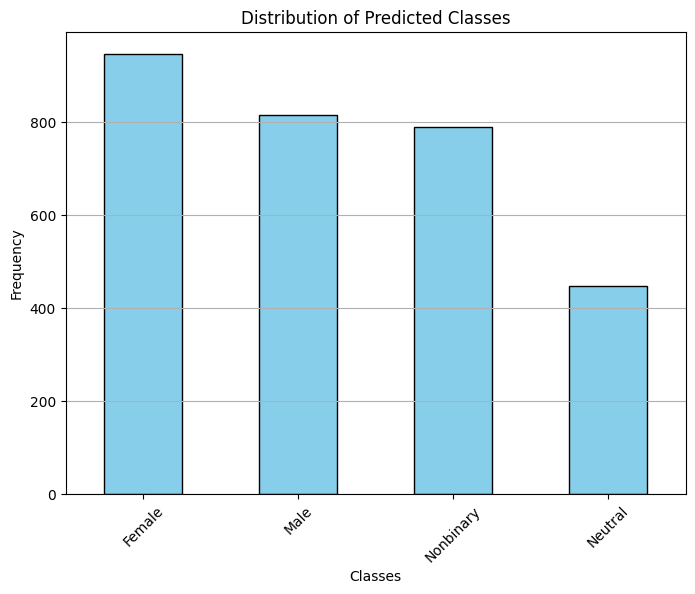

In [47]:
# Count the predicted class distribution
class_counts = submission_df['y_pred'].value_counts()

# Map numeric class labels to their respective string labels
class_labels = {0: 'Male', 1: 'Female', 2: 'Nonbinary', 3: 'Neutral'}

# Plot the distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Classes')
plt.xlabel('Classes')
plt.ylabel('Frequency')

# Update xticks with class labels
plt.xticks(ticks=range(len(class_counts)), labels=[class_labels[i] for i in class_counts.index], rotation=45)

plt.grid(axis='y')
plt.show()


# With LSTM

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ModifiedLSTMWithAttention(nn.Module):
    def __init__(self, embedding_dim=100, hidden_dim=8, output_dim=4):
        super(ModifiedLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        weighted_lstm_out = lstm_out * attention_weights
        context_vector = torch.sum(weighted_lstm_out, dim=1)
        output = self.fc(self.dropout(context_vector))
        return output

# Initialize model
model = ModifiedLSTMWithAttention()



In [61]:
# Dataset and DataLoader are the same as GRU model
train_dataset = GenderBiasDataset(train_df['embeddings'].tolist(), train_df['y'].tolist())
test_dataset = GenderBiasDataset(test_df['embeddings'].tolist())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store losses and times
lstm_losses = []
lstm_epoch_times = []
lstm_epoch_logs = []

# Training loop
for epoch in range(400):
    model.train()
    total_loss = 0
    start_time = time.time()  
    
    for batch in train_loader:
        optimizer.zero_grad()
        embeddings = batch['embedding']
        labels = batch['label']
        
        outputs = model(embeddings.unsqueeze(1))  
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    lstm_losses.append(avg_loss)  
    
    end_time = time.time() 
    epoch_time = end_time - start_time  
    lstm_epoch_times.append(epoch_time) 
    
    # Log epoch data
    epoch_logs.append({'Epoch': epoch + 1, 'Loss': avg_loss, 'Time (s)': epoch_time})
    
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")

# Save the model
torch.save(model.state_dict(), 'lstm_attention_model.pth')

Epoch 1, Loss: 1.3689, Time: 0.66s
Epoch 2, Loss: 1.2942, Time: 0.60s
Epoch 3, Loss: 1.1190, Time: 0.54s
Epoch 4, Loss: 0.9769, Time: 0.55s
Epoch 5, Loss: 0.8930, Time: 0.55s
Epoch 6, Loss: 0.8328, Time: 0.54s
Epoch 7, Loss: 0.7947, Time: 0.55s
Epoch 8, Loss: 0.7481, Time: 0.58s
Epoch 9, Loss: 0.7248, Time: 0.62s
Epoch 10, Loss: 0.7016, Time: 0.54s
Epoch 11, Loss: 0.6864, Time: 0.55s
Epoch 12, Loss: 0.6701, Time: 0.52s
Epoch 13, Loss: 0.6535, Time: 0.54s
Epoch 14, Loss: 0.6477, Time: 0.56s
Epoch 15, Loss: 0.6290, Time: 0.58s
Epoch 16, Loss: 0.6205, Time: 0.57s
Epoch 17, Loss: 0.6126, Time: 0.56s
Epoch 18, Loss: 0.6106, Time: 0.54s
Epoch 19, Loss: 0.6024, Time: 0.54s
Epoch 20, Loss: 0.5947, Time: 0.59s
Epoch 21, Loss: 0.5918, Time: 0.55s
Epoch 22, Loss: 0.5922, Time: 0.55s
Epoch 23, Loss: 0.5809, Time: 0.54s
Epoch 24, Loss: 0.5767, Time: 0.55s
Epoch 25, Loss: 0.5771, Time: 0.54s
Epoch 26, Loss: 0.5718, Time: 0.52s
Epoch 27, Loss: 0.5752, Time: 0.60s
Epoch 28, Loss: 0.5630, Time: 0.54s
E

     Epoch      Loss  Time (s)
0        1  0.409086  0.646439
99     100  0.397930  0.538266
199    200  0.380193  0.543502
299    300  0.366663  0.553275
399    400  0.353444  1.098491
400      1  1.368871  0.656261
499    100  0.463870  0.571644
599    200  0.418929  0.512430
699    300  0.400843  0.507041
799    400  0.386403  1.005594


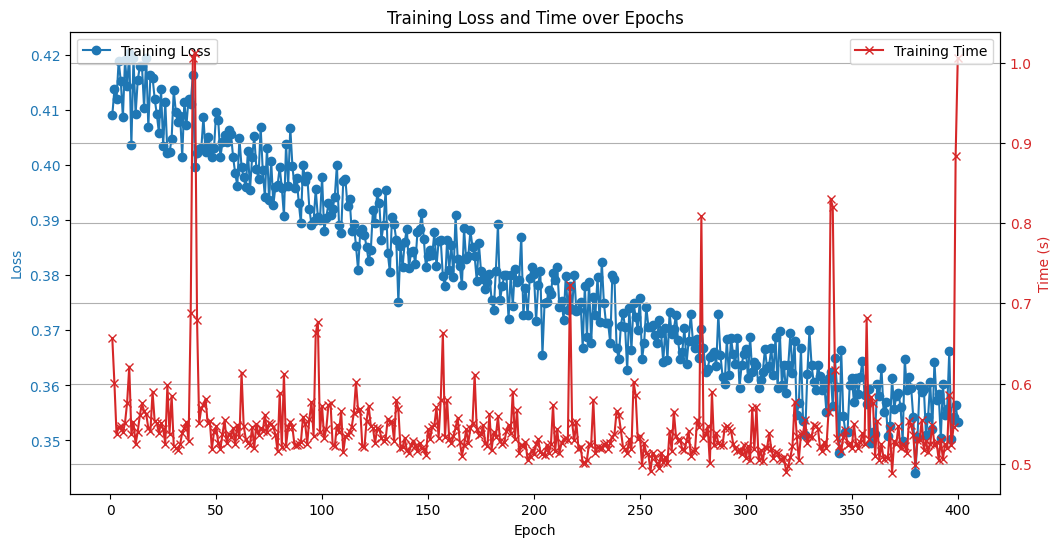

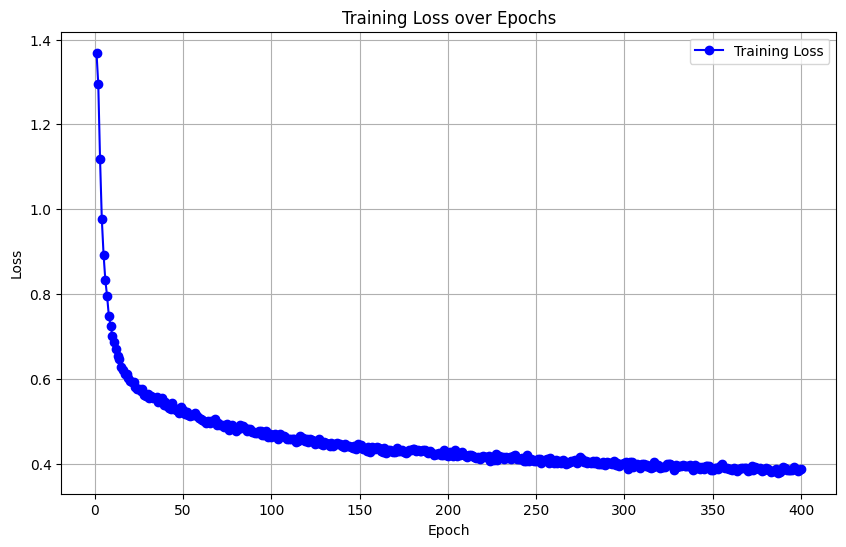

In [63]:
# Convert epoch logs to a DataFrame for better visualization
df_logs = pd.DataFrame(epoch_logs)

key_epochs = [1, 100, 200,300,400]
df_key_epochs = df_logs[df_logs['Epoch'].isin(key_epochs)]
print(df_key_epochs)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(lstm_losses) + 1), losses, marker='o', color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # Create a second y-axis for time
color = 'tab:red'
ax2.set_ylabel('Time (s)', color=color)
ax2.plot(range(1, len(lstm_epoch_times) + 1), lstm_epoch_times, marker='x', color=color, label='Training Time')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Training Loss and Time over Epochs')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(lstm_losses) + 1), lstm_losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

In [52]:
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
import torch
import pandas as pd
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
from thop import profile
from sklearn.metrics import classification_report

# Load the trained LSTM model
model = ModifiedLSTMWithAttention()
model.load_state_dict(torch.load('lstm_attention_model.pth'))
model.eval() 

# Define a function to calculate NOP using thop
def measure_nop(model, inputs):
    flops, params = profile(model, inputs=(inputs['embedding'],))  # Use the 'embedding' as input
    return flops, params

# Calculate NOP once
sample_input = torch.randn(1, 1, 100)  # Adjust shape to (batch_size, seq_len, embedding_dim)
flops, num_params = measure_nop(model, {'embedding': sample_input})

# List to hold predictions and number of parameters
predictions = []
NOP = []

# Start time for inference
start_time = time.time()

# Make predictions for each batch in the test set
for idx, batch in enumerate(test_loader):
    embeddings = batch['embedding']  
    with torch.no_grad():  
        outputs = model(embeddings.unsqueeze(1)) 
        _, preds = torch.max(outputs, 1) 

    predictions.extend(preds.cpu().numpy()) 
    NOP.extend([num_params] * len(preds))

# End time for inference
end_time = time.time()
inference_time = end_time - start_time
print(f"Total Inference Time for Test Set: {inference_time:.2f} seconds")

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'], 
    'y_pred': predictions,
    'parameters': NOP
})

# Save the submission DataFrame to CSV
submission_df.to_csv("submission_lstm.csv", index=False, mode='w')
print("Predictions and NOP saved to submission.csv")


[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Total Inference Time for Test Set: 0.09 seconds
Predictions and NOP saved to submission.csv


/tmp/ipykernel_30/4027843751.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_attention_model.pth'))


[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


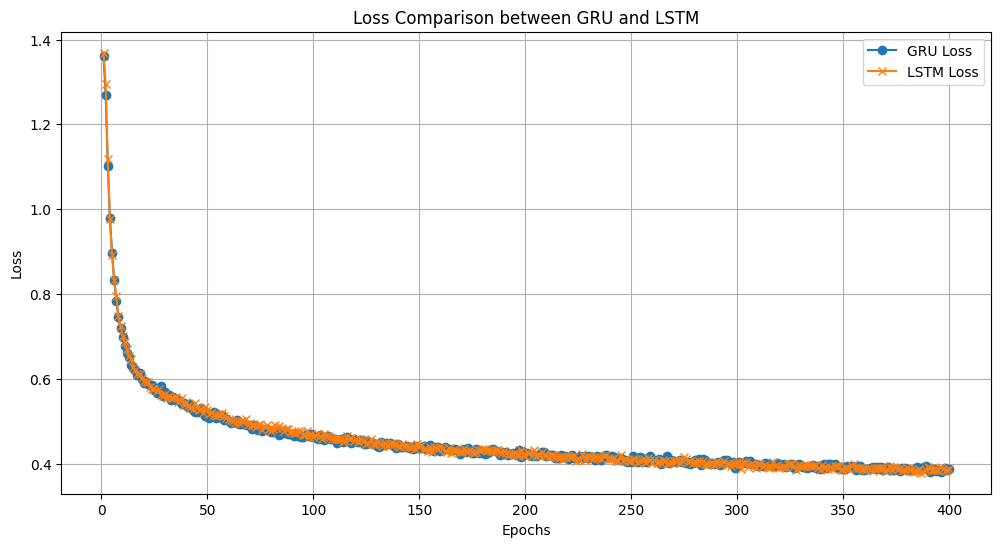

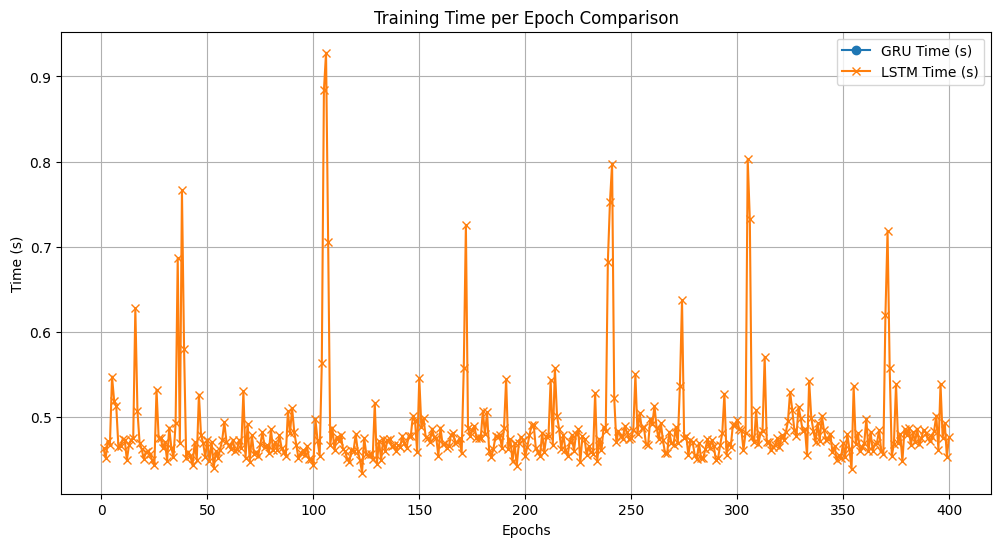

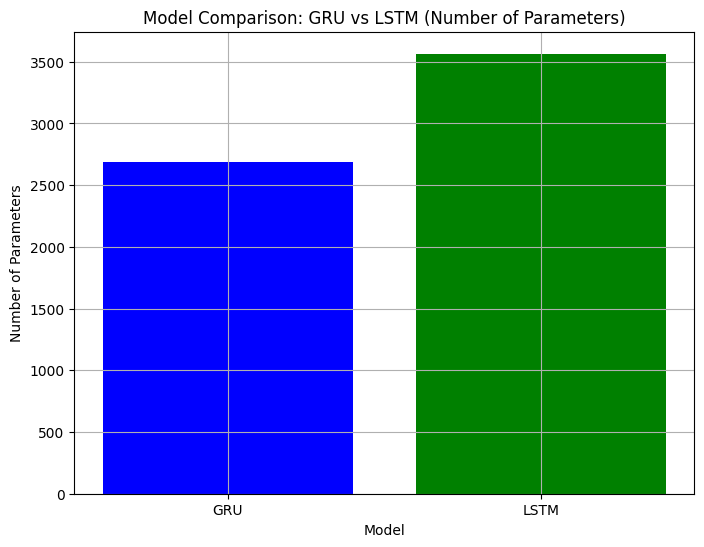

In [71]:
import matplotlib.pyplot as plt
import torch
from thop import profile

# Calculate Number of Parameters (NOP) for GRU and LSTM models
def measure_nop(model, inputs):
    flops, params = profile(model, inputs=(inputs['embedding'],))  # Use the 'embedding' as input
    return flops, params

# Initialize sample input for NOP calculation
sample_input = torch.randn(1, 1, 100)  # Adjust shape to (batch_size, seq_len, embedding_dim)

# Measure NOP for both models
flops_gru, num_params_gru = measure_nop(gru_model, {'embedding': sample_input})
flops_lstm, num_params_lstm = measure_nop(lstm_model, {'embedding': sample_input})

# Store NOP for each model
nop_comparison = {'GRU': num_params_gru, 'LSTM': num_params_lstm}

# Start by plotting the loss for both models
plt.figure(figsize=(12, 6))

# Plot Loss for GRU
plt.plot(range(1, len(losses) + 1), losses, label='GRU Loss', marker='o')

# Plot Loss for LSTM
plt.plot(range(1, len(lstm_losses) + 1), lstm_losses, label='LSTM Loss', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison between GRU and LSTM')
plt.legend()
plt.grid(True)
plt.show()

# Plot Time per Epoch for GRU and LSTM
plt.figure(figsize=(12, 6))

# Plot Time for GRU
plt.plot(range(1, len(gru_epoch_times) + 1), gru_epoch_times, label='GRU Time (s)', marker='o')

# Plot Time for LSTM
plt.plot(range(1, len(epoch_times) + 1), epoch_times, label='LSTM Time (s)', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Time (s)')
plt.title('Training Time per Epoch Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Bar chart to compare the number of parameters (NOP) between GRU and LSTM
plt.figure(figsize=(8, 6))
models = ['GRU', 'LSTM']
params = [nop_comparison['GRU'], nop_comparison['LSTM']]
plt.bar(models, params, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Number of Parameters')
plt.title('Model Comparison: GRU vs LSTM (Number of Parameters)')
plt.grid(True)
plt.show()
